In [7]:
# ============================
# SEL 1: INSTALL DAN IMPORT LIBRARY
# ============================

# Install library yang diperlukan (jalankan sekali)
!pip install simpy plotly pandas numpy ipywidgets

# Import library
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from dataclasses import dataclass
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Konfigurasi tampilan
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Library berhasil diimport!")

✅ Library berhasil diimport!



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# ============================
# SEL 2: KONFIGURASI SIMULASI
# ============================

@dataclass
class Config:
    """Konfigurasi parameter simulasi piket IT Del"""
    
    # JUMLAH MEJA DAN MAHASISWA
    NUM_MEJA: int = 60
    MAHASISWA_PER_MEJA: int = 3
    
    @property
    def TOTAL_OMPRENG(self):
        return self.NUM_MEJA * self.MAHASISWA_PER_MEJA
    
    # JUMLAH PETUGAS (7 ORANG)
    STAFF_LAUK: int = 2
    STAFF_ANGKAT: int = 2
    STAFF_NASI: int = 3
    
    # WAKTU LAYANAN (dalam menit)
    LAUK_MIN: float = 0.17    # ~10 detik
    LAUK_MAX: float = 0.30    # ~18 detik
    
    ANGKAT_MIN: float = 0.17   # ~10 detik
    ANGKAT_MAX: float = 0.30   # ~18 detik
    ANGKAT_BATCH_MIN: int = 5
    ANGKAT_BATCH_MAX: int = 8
    
    NASI_MIN: float = 0.17     # ~10 detik
    NASI_MAX: float = 0.30     # ~18 detik
    
    START_HOUR: int = 7
    START_MINUTE: int = 0
    RANDOM_SEED: int = 42
    
    def __post_init__(self):
        print("📊 Konfigurasi Simulasi:")
        print(f"   - Total Ompreng: {self.TOTAL_OMPRENG} (60 meja × 3 mahasiswa)")
        print(f"   - Staff Lauk: {self.STAFF_LAUK} orang")
        print(f"   - Staff Angkat: {self.STAFF_ANGKAT} orang")
        print(f"   - Staff Nasi: {self.STAFF_NASI} orang")
        print(f"   - Waktu Layanan: {self.LAUK_MIN*60:.0f}-{self.LAUK_MAX*60:.0f} detik")

# Buat konfigurasi default
config_default = Config()

📊 Konfigurasi Simulasi:
   - Total Ompreng: 180 (60 meja × 3 mahasiswa)
   - Staff Lauk: 2 orang
   - Staff Angkat: 2 orang
   - Staff Nasi: 3 orang
   - Waktu Layanan: 10-18 detik


In [9]:
# ============================
# SEL 3: MODEL SIMULASI
# ============================

class SistemPiketITDel:
    def __init__(self, config: Config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources (petugas)
        self.lauk = simpy.Resource(self.env, capacity=config.STAFF_LAUK)
        self.angkat = simpy.Resource(self.env, capacity=config.STAFF_ANGKAT)
        self.nasi = simpy.Resource(self.env, capacity=config.STAFF_NASI)
        
        # Antrian
        self.antrian_lauk = simpy.Store(self.env)
        self.antrian_nasi = simpy.Store(self.env)
        self.buffer_angkat = []
        
        # Statistik
        self.statistics = {
            'ompreng_data': [],
            'waktu_tunggu_lauk': [],
            'waktu_tunggu_angkat': [],
            'waktu_tunggu_nasi': [],
            'waktu_layanan_lauk': [],
            'waktu_layanan_angkat': [],
            'waktu_layanan_nasi': [],
            'batch_sizes': [],
            'utilization': {'lauk': [], 'angkat': [], 'nasi': []}
        }
        
        # Waktu mulai
        self.start_time = datetime(2024, 1, 1, config.START_HOUR, config.START_MINUTE)
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
        
        # Counter
        self.ompreng_diproses = 0
        self.ompreng_total = config.TOTAL_OMPRENG
        self.batch_count = 0
    
    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        """Konversi waktu simulasi ke datetime"""
        return self.start_time + timedelta(minutes=waktu_simulasi)
    
    def generate_lauk_time(self): 
        return random.uniform(self.config.LAUK_MIN, self.config.LAUK_MAX)
    
    def generate_angkat_time(self): 
        return random.uniform(self.config.ANGKAT_MIN, self.config.ANGKAT_MAX)
    
    def generate_batch_size(self): 
        return random.randint(self.config.ANGKAT_BATCH_MIN, self.config.ANGKAT_BATCH_MAX)
    
    def generate_nasi_time(self): 
        return random.uniform(self.config.NASI_MIN, self.config.NASI_MAX)
    
    def proses_lauk(self, ompreng_id: int):
        """Proses pengambilan lauk"""
        waktu_datang = self.env.now
        
        # Masuk antrian lauk
        yield self.antrian_lauk.put(ompreng_id)
        
        # Ambil petugas lauk
        with self.lauk.request() as request:
            yield request
            yield self.antrian_lauk.get()
            
            # Catat utilisasi
            self.statistics['utilization']['lauk'].append({
                'time': self.env.now,
                'in_use': self.lauk.count
            })
            
            # Proses lauk
            lauk_time = self.generate_lauk_time()
            yield self.env.timeout(lauk_time)
            
            # Catat statistik
            self.statistics['waktu_layanan_lauk'].append(lauk_time)
            self.statistics['waktu_tunggu_lauk'].append(self.env.now - waktu_datang - lauk_time)
        
        # Masuk buffer angkat
        self.buffer_angkat.append({
            'id': ompreng_id,
            'waktu_masuk': self.env.now
        })
    
    def proses_angkat(self):
        """Proses pengangkatan (batch)"""
        while self.ompreng_diproses < self.ompreng_total:
            # Tentukan target batch
            batch_target = self.generate_batch_size()
            
            # Tunggu sampai buffer cukup atau tidak ada ompreng lagi
            while len(self.buffer_angkat) < batch_target and len(self.buffer_angkat) + self.ompreng_diproses < self.ompreng_total:
                yield self.env.timeout(0.1)
            
            if self.buffer_angkat:
                # Tentukan ukuran batch aktual
                batch_size = min(batch_target, len(self.buffer_angkat))
                
                # Ambil batch dari buffer
                batch = self.buffer_angkat[:batch_size]
                self.buffer_angkat = self.buffer_angkat[batch_size:]
                
                # Catat statistik batch
                self.batch_count += 1
                self.statistics['batch_sizes'].append(batch_size)
                
                # Catat waktu tunggu untuk setiap ompreng dalam batch
                for item in batch:
                    self.statistics['waktu_tunggu_angkat'].append(self.env.now - item['waktu_masuk'])
                
                # Proses pengangkatan
                with self.angkat.request() as request:
                    yield request
                    self.statistics['utilization']['angkat'].append({
                        'time': self.env.now, 
                        'in_use': self.angkat.count
                    })
                    
                    angkat_time = self.generate_angkat_time()
                    yield self.env.timeout(angkat_time)
                    self.statistics['waktu_layanan_angkat'].append(angkat_time)
                
                # Kirim ke proses nasi
                for item in batch:
                    yield self.antrian_nasi.put(item['id'])
                    self.env.process(self.proses_nasi(item['id']))
            else:
                yield self.env.timeout(0.1)
    
    def proses_nasi(self, ompreng_id: int):
        """Proses pengambilan nasi"""
        waktu_masuk = self.env.now
        
        with self.nasi.request() as request:
            yield request
            self.statistics['utilization']['nasi'].append({
                'time': self.env.now, 
                'in_use': self.nasi.count
            })
            
            nasi_time = self.generate_nasi_time()
            yield self.env.timeout(nasi_time)
            
            # Catat statistik
            self.statistics['waktu_layanan_nasi'].append(nasi_time)
            self.statistics['waktu_tunggu_nasi'].append(self.env.now - waktu_masuk - nasi_time)
            
            # Ompreng selesai
            self.statistics['ompreng_data'].append({
                'id': ompreng_id,
                'waktu_selesai': self.env.now,
                'jam_selesai': self.waktu_ke_jam(self.env.now)
            })
            
            self.ompreng_diproses += 1
    
    def run_simulation(self):
        """Jalankan simulasi"""
        print("🚀 Menjalankan simulasi...")
        
        # Reset state
        self.ompreng_diproses = 0
        self.buffer_angkat = []
        self.batch_count = 0
        
        # Proses angkat sebagai background process
        self.env.process(self.proses_angkat())
        
        # Buat proses lauk untuk setiap ompreng
        for i in range(self.ompreng_total):
            self.env.process(self.proses_lauk(i))
        
        # Jalankan simulasi
        self.env.run()
        
        print(f"✅ Simulasi selesai! {self.ompreng_diproses} ompreng terproses")
        
        return self.analyze_results()
    
    def analyze_results(self):
        """Analisis hasil simulasi"""
        if not self.statistics['ompreng_data']:
            return None, None
        
        df = pd.DataFrame(self.statistics['ompreng_data'])
        
        # Hitung metrics
        results = {
            'total_ompreng': len(df),
            'waktu_selesai_terakhir': df['waktu_selesai'].max(),
            'jam_selesai_terakhir': self.waktu_ke_jam(df['waktu_selesai'].max()),
            'avg_waktu_tunggu_lauk': np.mean(self.statistics['waktu_tunggu_lauk']) * 60 if self.statistics['waktu_tunggu_lauk'] else 0,
            'avg_waktu_tunggu_angkat': np.mean(self.statistics['waktu_tunggu_angkat']) * 60 if self.statistics['waktu_tunggu_angkat'] else 0,
            'avg_waktu_tunggu_nasi': np.mean(self.statistics['waktu_tunggu_nasi']) * 60 if self.statistics['waktu_tunggu_nasi'] else 0,
            'avg_waktu_layanan_lauk': np.mean(self.statistics['waktu_layanan_lauk']) * 60,
            'avg_waktu_layanan_angkat': np.mean(self.statistics['waktu_layanan_angkat']) * 60,
            'avg_waktu_layanan_nasi': np.mean(self.statistics['waktu_layanan_nasi']) * 60,
            'avg_batch_size': np.mean(self.statistics['batch_sizes']) if self.statistics['batch_sizes'] else 0,
            'total_batch': len(self.statistics['batch_sizes']),
            'utilisasi_lauk': 0,
            'utilisasi_angkat': 0,
            'utilisasi_nasi': 0
        }
        
        # Hitung utilisasi
        total_time = results['waktu_selesai_terakhir']
        if total_time > 0:
            total_lauk = sum(self.statistics['waktu_layanan_lauk'])
            results['utilisasi_lauk'] = (total_lauk / (total_time * self.config.STAFF_LAUK)) * 100
            
            total_angkat = sum(self.statistics['waktu_layanan_angkat'])
            results['utilisasi_angkat'] = (total_angkat / (total_time * self.config.STAFF_ANGKAT)) * 100
            
            total_nasi = sum(self.statistics['waktu_layanan_nasi'])
            results['utilisasi_nasi'] = (total_nasi / (total_time * self.config.STAFF_NASI)) * 100
        
        return results, df

In [10]:
# ============================
# SEL 4: FUNGSI VISUALISASI
# ============================

def create_summary_table(results):
    """Buat tabel ringkasan hasil"""
    if not results:
        return None
    
    summary_data = {
        'Metric': [
            'Waktu Selesai',
            'Durasi Total (menit)',
            'Total Batch',
            'Rata-rata Batch Size',
            'Rata-rata Waktu Tunggu Lauk (detik)',
            'Rata-rata Waktu Tunggu Angkat (detik)',
            'Rata-rata Waktu Tunggu Nasi (detik)',
            'Rata-rata Waktu Layanan Lauk (detik)',
            'Rata-rata Waktu Layanan Angkat (detik)',
            'Rata-rata Waktu Layanan Nasi (detik)',
            'Utilisasi Lauk (%)',
            'Utilisasi Angkat (%)',
            'Utilisasi Nasi (%)'
        ],
        'Value': [
            results['jam_selesai_terakhir'].strftime('%H:%M:%S'),
            f"{results['waktu_selesai_terakhir']:.2f}",
            f"{results['total_batch']}",
            f"{results['avg_batch_size']:.2f}",
            f"{results['avg_waktu_tunggu_lauk']:.2f}",
            f"{results['avg_waktu_tunggu_angkat']:.2f}",
            f"{results['avg_waktu_tunggu_nasi']:.2f}",
            f"{results['avg_waktu_layanan_lauk']:.2f}",
            f"{results['avg_waktu_layanan_angkat']:.2f}",
            f"{results['avg_waktu_layanan_nasi']:.2f}",
            f"{results['utilisasi_lauk']:.2f}%",
            f"{results['utilisasi_angkat']:.2f}%",
            f"{results['utilisasi_nasi']:.2f}%"
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    return df_summary

def plot_timeline_chart(df):
    """Plot timeline penyelesaian per menit"""
    if df.empty:
        return None
    
    df['jam'] = df['jam_selesai'].dt.hour
    df['menit'] = df['jam_selesai'].dt.minute
    df['waktu'] = df['jam'].astype(str) + ':' + df['menit'].astype(str).str.zfill(2)
    
    # Hitung frekuensi per waktu
    time_dist = df['waktu'].value_counts().sort_index()
    
    fig = px.bar(
        x=time_dist.index,
        y=time_dist.values,
        title='📊 Distribusi Waktu Penyelesaian Ompreng',
        labels={'x': 'Waktu', 'y': 'Jumlah Ompreng Selesai'},
        color=time_dist.values,
        color_continuous_scale='Viridis'
    )
    
    fig.update_layout(
        xaxis_title="Jam",
        yaxis_title="Jumlah Ompreng",
        showlegend=False,
        height=400
    )
    
    return fig

def plot_waiting_times(model):
    """Plot distribusi waktu tunggu"""
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Lauk', 'Angkat', 'Nasi'),
        shared_yaxes=True
    )
    
    # Lauk
    if model.statistics['waktu_tunggu_lauk']:
        fig.add_trace(
            go.Histogram(
                x=np.array(model.statistics['waktu_tunggu_lauk']) * 60,
                name='Lauk',
                marker_color='blue',
                nbinsx=20
            ),
            row=1, col=1
        )
    
    # Angkat
    if model.statistics['waktu_tunggu_angkat']:
        fig.add_trace(
            go.Histogram(
                x=np.array(model.statistics['waktu_tunggu_angkat']) * 60,
                name='Angkat',
                marker_color='orange',
                nbinsx=20
            ),
            row=1, col=2
        )
    
    # Nasi
    if model.statistics['waktu_tunggu_nasi']:
        fig.add_trace(
            go.Histogram(
                x=np.array(model.statistics['waktu_tunggu_nasi']) * 60,
                name='Nasi',
                marker_color='green',
                nbinsx=20
            ),
            row=1, col=3
        )
    
    fig.update_layout(
        title_text='📊 Distribusi Waktu Tunggu per Tahap (detik)',
        showlegend=False,
        height=400
    )
    
    fig.update_xaxes(title_text="Detik", row=1, col=1)
    fig.update_xaxes(title_text="Detik", row=1, col=2)
    fig.update_xaxes(title_text="Detik", row=1, col=3)
    fig.update_yaxes(title_text="Frekuensi", row=1, col=1)
    
    return fig

def plot_batch_distribution(model):
    """Plot distribusi ukuran batch"""
    if not model.statistics['batch_sizes']:
        return None
    
    fig = px.histogram(
        x=model.statistics['batch_sizes'],
        nbins=model.config.ANGKAT_BATCH_MAX - model.config.ANGKAT_BATCH_MIN + 1,
        title='📦 Distribusi Ukuran Batch Pengangkatan',
        labels={'x': 'Ukuran Batch (ompreng)', 'y': 'Frekuensi'},
        color_discrete_sequence=['orange']
    )
    
    fig.update_layout(height=400)
    return fig

def plot_utilization_gauge(results):
    """Plot gauge chart untuk utilisasi"""
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]],
        subplot_titles=('Lauk (2 org)', 'Angkat (2 org)', 'Nasi (3 org)')
    )
    
    # Lauk
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=results['utilisasi_lauk'],
            title={'text': "Utilisasi"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "blue"},
                'steps': [
                    {'range': [0, 50], 'color': "lightgray"},
                    {'range': [50, 80], 'color': "gray"},
                    {'range': [80, 100], 'color': "darkgray"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 90
                }
            }
        ),
        row=1, col=1
    )
    
    # Angkat
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=results['utilisasi_angkat'],
            title={'text': "Utilisasi"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "orange"},
                'steps': [
                    {'range': [0, 50], 'color': "lightgray"},
                    {'range': [50, 80], 'color': "gray"},
                    {'range': [80, 100], 'color': "darkgray"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 90
                }
            }
        ),
        row=1, col=2
    )
    
    # Nasi
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=results['utilisasi_nasi'],
            title={'text': "Utilisasi"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "green"},
                'steps': [
                    {'range': [0, 50], 'color': "lightgray"},
                    {'range': [50, 80], 'color': "gray"},
                    {'range': [80, 100], 'color': "darkgray"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 90
                }
            }
        ),
        row=1, col=3
    )
    
    fig.update_layout(height=300)
    return fig

def plot_throughput_time(df):
    """Plot waktu penyelesaian per ompreng"""
    if df.empty:
        return None
    
    df_sorted = df.sort_values('id')
    
    fig = px.line(
        df_sorted,
        x='id',
        y='waktu_selesai',
        title='⏱️ Waktu Penyelesaian per Ompreng',
        labels={'id': 'ID Ompreng', 'waktu_selesai': 'Waktu Selesai (menit)'},
        markers=True
    )
    
    fig.update_layout(height=400)
    return fig

In [11]:
# ============================
# SEL 5: FUNGSI INTERAKTIF DENGAN WIDGET
# ============================

def create_interactive_controls():
    """Buat kontrol interaktif untuk simulasi"""
    
    style = {'description_width': 'initial'}
    
    # Slider untuk target waktu
    target_time = widgets.Dropdown(
        options=['15 menit', '20 menit', '25 menit', '30 menit', '35 menit', '40 menit'],
        value='20 menit',
        description='Target waktu:',
        style=style,
        layout=widgets.Layout(width='300px')
    )
    
    # Informasi staff
    staff_info = widgets.HTML(
        value="""
        <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px; margin-bottom: 10px;">
            <b>👥 7 Orang Mahasiswa</b><br>
            - Lauk: 2 orang<br>
            - Angkat: 2 orang<br>
            - Nasi: 3 orang
        </div>
        """
    )
    
    # Tombol run
    run_button = widgets.Button(
        description='🚀 Jalankan Simulasi',
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px', margin='10px 0px')
    )
    
    # Output area
    output = widgets.Output()
    
    return target_time, staff_info, run_button, output

def run_simulation_with_params(target):
    """Jalankan simulasi dengan parameter tertentu"""
    
    # Tentukan faktor berdasarkan target
    target_map = {
        '15 menit': (0.7, 15),
        '20 menit': (1.0, 20),
        '25 menit': (1.3, 25),
        '30 menit': (1.6, 30),
        '35 menit': (1.9, 35),
        '40 menit': (2.2, 40)
    }
    
    faktor, target_menit = target_map[target]
    
    # Hitung waktu layanan
    base_time = 0.17
    
    # Buat konfigurasi
    config = Config(
        LAUK_MIN=base_time * faktor,
        LAUK_MAX=base_time * 1.8 * faktor,
        ANGKAT_MIN=base_time * faktor,
        ANGKAT_MAX=base_time * 1.8 * faktor,
        NASI_MIN=base_time * faktor,
        NASI_MAX=base_time * 1.8 * faktor
    )
    
    # Tampilkan parameter
    print("📊 Parameter Simulasi:")
    print(f"   Target: {target}")
    print(f"   Waktu lauk: {config.LAUK_MIN*60:.0f}-{config.LAUK_MAX*60:.0f} detik")
    print(f"   Waktu angkat: {config.ANGKAT_MIN*60:.0f}-{config.ANGKAT_MAX*60:.0f} detik")
    print(f"   Waktu nasi: {config.NASI_MIN*60:.0f}-{config.NASI_MAX*60:.0f} detik")
    print("-" * 50)
    
    # Jalankan simulasi
    model = SistemPiketITDel(config)
    results, df = model.run_simulation()
    
    return model, results, df, target_menit

In [15]:
# ============================
# SEL 6: SIMULASI INTERAKTIF
# ============================

# Buat kontrol
target_time, staff_info, run_button, output = create_interactive_controls()

# Tampilkan kontrol
display(HTML("<h2>🎮 Simulasi Piket IT Del</h2>"))
display(staff_info)
display(target_time)
display(run_button)
display(output)

# Variable untuk menyimpan hasil terakhir
last_results = None
last_model = None
last_df = None

# Fungsi callback untuk tombol
def on_run_button_clicked(b):
    global last_results, last_model, last_df
    
    with output:
        clear_output(wait=True)
        model, results, df, target_menit = run_simulation_with_params(target_time.value)
        
        if results and df is not None and not df.empty:
            last_results = results
            last_model = model
            last_df = df
            
            # Tampilkan hasil
            display(HTML("<h3>📈 Hasil Simulasi</h3>"))
            
            # Metrics dalam format HTML
            html_metrics = f"""
            <div style="display: flex; gap: 20px; margin-bottom: 20px; flex-wrap: wrap;">
                <div style="background-color: #f0f0f0; padding: 15px; border-radius: 10px; flex: 1; min-width: 150px; text-align: center;">
                    <b>⏱️ Selesai</b><br>
                    <span style="font-size: 24px; font-weight: bold;">{results['jam_selesai_terakhir'].strftime('%H:%M')}</span>
                </div>
                <div style="background-color: #f0f0f0; padding: 15px; border-radius: 10px; flex: 1; min-width: 150px; text-align: center;">
                    <b>⏰ Durasi</b><br>
                    <span style="font-size: 24px; font-weight: bold;">{results['waktu_selesai_terakhir']:.1f} menit</span>
                </div>
                <div style="background-color: #f0f0f0; padding: 15px; border-radius: 10px; flex: 1; min-width: 150px; text-align: center;">
                    <b>📦 Total Batch</b><br>
                    <span style="font-size: 24px; font-weight: bold;">{results['total_batch']}</span>
                </div>
                <div style="background-color: #f0f0f0; padding: 15px; border-radius: 10px; flex: 1; min-width: 150px; text-align: center;">
                    <b>📊 Rata-rata Batch</b><br>
                    <span style="font-size: 24px; font-weight: bold;">{results['avg_batch_size']:.1f}</span>
                </div>
            </div>
            """
            
            display(HTML(html_metrics))
            
            # Tabel ringkasan
            display(HTML("<h4>📋 Detail Hasil</h4>"))
            df_summary = create_summary_table(results)
            if df_summary is not None:
                # Styling tabel
                styled_df = df_summary.style.set_properties(**{
                    'text-align': 'left',
                    'padding': '8px',
                    'border': '1px solid #ddd'
                }).set_table_styles([
                    {'selector': 'th', 'props': [('background-color', '#4CAF50'), 
                                                  ('color', 'white'),
                                                  ('padding', '10px')]}
                ])
                display(styled_df)
            
            # Visualisasi
            display(HTML("<h4>📊 Visualisasi</h4>"))
            
            # Utilisasi gauge
            fig_gauge = plot_utilization_gauge(results)
            if fig_gauge:
                fig_gauge.show()
            
            # Waiting times
            fig_wait = plot_waiting_times(model)
            if fig_wait:
                fig_wait.show()
            
            # Batch distribution
            fig_batch = plot_batch_distribution(model)
            if fig_batch:
                fig_batch.show()
            
            # Timeline
            fig_timeline = plot_timeline_chart(df)
            if fig_timeline:
                fig_timeline.show()
            
            # Throughput
            fig_throughput = plot_throughput_time(df)
            if fig_throughput:
                fig_throughput.show()
            
            # Download link untuk CSV (menggunakan ipywidgets)
            csv_data = df.to_csv(index=False)
            
            # Buat tombol download dengan JavaScript
            download_button = widgets.Button(
                description='📥 Download Data CSV',
                button_style='primary',
                layout=widgets.Layout(width='200px', margin='20px 0px')
            )
            
            # Fungsi untuk download
            def download_csv(b):
                from IPython.display import Javascript
                js_code = f"""
                var csvContent = `{csv_data}`;
                var blob = new Blob([csvContent], {{ type: 'text/csv' }});
                var a = document.createElement('a');
                a.href = URL.createObjectURL(blob);
                a.download = 'piket_simulation_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv';
                document.body.appendChild(a);
                a.click();
                document.body.removeChild(a);
                """
                display(Javascript(js_code))
            
            download_button.on_click(download_csv)
            display(download_button)
            
        else:
            display(HTML("<div style='color: red; padding: 20px; background-color: #ffeeee; border-radius: 5px;'>❌ Gagal menjalankan simulasi!</div>"))

# Hubungkan callback
run_button.on_click(on_run_button_clicked)

# Jalankan sekali untuk inisialisasi
print("👆 Klik tombol 'Jalankan Simulasi' untuk memulai!")

HTML(value='\n        <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px; margin-bottom:…

Dropdown(description='Target waktu:', index=1, layout=Layout(width='300px'), options=('15 menit', '20 menit', …

Button(button_style='success', description='🚀 Jalankan Simulasi', layout=Layout(height='40px', margin='10px 0p…

Output()

👆 Klik tombol 'Jalankan Simulasi' untuk memulai!


,Tahap,Rata-rata,Min,Max,Std Dev
0,Lauk,617.11,0.00,1249.52,364.55
1,Angkat,22.78,0.09,54.68,14.21
2,Nasi,9.01,-0.00,31.99,9.14


,Tahap,Rata-rata,Min,Max
0,Lauk,14.03,10.20,18.35
1,Angkat,13.73,10.56,18.01
2,Nasi,14.25,10.21,18.34


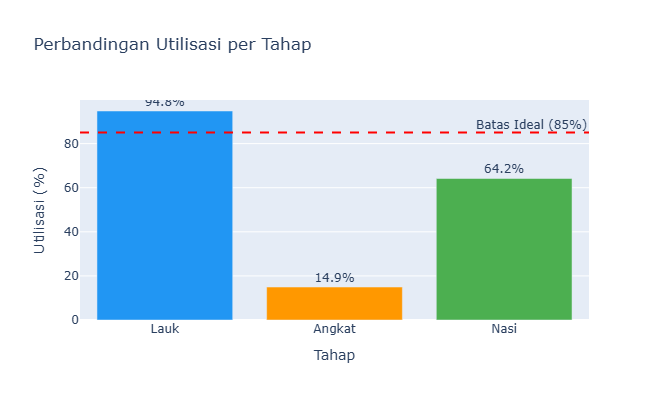

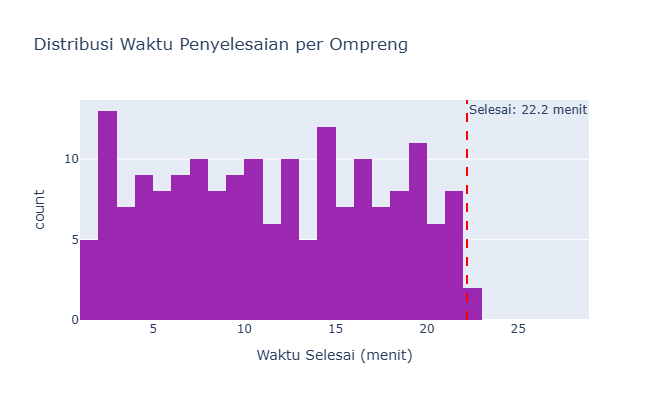

Metric,Value
Waktu Mulai,07:00
Waktu Selesai,07:22
Total Durasi,22.20 menit
Rata-rata per Ompreng,7.40 detik
Ompreng per Menit,8.11


In [16]:
# ============================
# SEL 7: ANALISIS LANJUTAN
# ============================

# Sel ini hanya bisa dijalankan setelah simulasi dilakukan
if 'last_results' in globals() and last_results is not None and 'last_df' in globals() and last_df is not None:
    display(HTML("<h2 style='color: #2E4053; margin-top: 30px;'>🔍 Analisis Lanjutan</h2>"))
    
    # Statistik deskriptif waktu tunggu
    display(HTML("<h3 style='color: #5D6D7E;'>📊 Statistik Waktu Tunggu (detik)</h3>"))
    
    waiting_stats = pd.DataFrame({
        'Tahap': ['Lauk', 'Angkat', 'Nasi'],
        'Rata-rata': [
            last_results['avg_waktu_tunggu_lauk'],
            last_results['avg_waktu_tunggu_angkat'],
            last_results['avg_waktu_tunggu_nasi']
        ],
        'Min': [
            min(last_model.statistics['waktu_tunggu_lauk']) * 60 if last_model.statistics['waktu_tunggu_lauk'] else 0,
            min(last_model.statistics['waktu_tunggu_angkat']) * 60 if last_model.statistics['waktu_tunggu_angkat'] else 0,
            min(last_model.statistics['waktu_tunggu_nasi']) * 60 if last_model.statistics['waktu_tunggu_nasi'] else 0
        ],
        'Max': [
            max(last_model.statistics['waktu_tunggu_lauk']) * 60 if last_model.statistics['waktu_tunggu_lauk'] else 0,
            max(last_model.statistics['waktu_tunggu_angkat']) * 60 if last_model.statistics['waktu_tunggu_angkat'] else 0,
            max(last_model.statistics['waktu_tunggu_nasi']) * 60 if last_model.statistics['waktu_tunggu_nasi'] else 0
        ],
        'Std Dev': [
            np.std(last_model.statistics['waktu_tunggu_lauk']) * 60 if last_model.statistics['waktu_tunggu_lauk'] else 0,
            np.std(last_model.statistics['waktu_tunggu_angkat']) * 60 if last_model.statistics['waktu_tunggu_angkat'] else 0,
            np.std(last_model.statistics['waktu_tunggu_nasi']) * 60 if last_model.statistics['waktu_tunggu_nasi'] else 0
        ]
    })
    
    # Styling tabel
    styled_waiting = waiting_stats.style.background_gradient(cmap='Blues', subset=['Rata-rata', 'Min', 'Max', 'Std Dev'])
    styled_waiting = styled_waiting.format({
        'Rata-rata': '{:.2f}',
        'Min': '{:.2f}',
        'Max': '{:.2f}',
        'Std Dev': '{:.2f}'
    })
    display(styled_waiting)
    
    # Statistik waktu layanan
    display(HTML("<h3 style='color: #5D6D7E; margin-top: 30px;'>⚙️ Statistik Waktu Layanan (detik)</h3>"))
    
    service_stats = pd.DataFrame({
        'Tahap': ['Lauk', 'Angkat', 'Nasi'],
        'Rata-rata': [
            last_results['avg_waktu_layanan_lauk'],
            last_results['avg_waktu_layanan_angkat'],
            last_results['avg_waktu_layanan_nasi']
        ],
        'Min': [
            min(last_model.statistics['waktu_layanan_lauk']) * 60 if last_model.statistics['waktu_layanan_lauk'] else 0,
            min(last_model.statistics['waktu_layanan_angkat']) * 60 if last_model.statistics['waktu_layanan_angkat'] else 0,
            min(last_model.statistics['waktu_layanan_nasi']) * 60 if last_model.statistics['waktu_layanan_nasi'] else 0
        ],
        'Max': [
            max(last_model.statistics['waktu_layanan_lauk']) * 60 if last_model.statistics['waktu_layanan_lauk'] else 0,
            max(last_model.statistics['waktu_layanan_angkat']) * 60 if last_model.statistics['waktu_layanan_angkat'] else 0,
            max(last_model.statistics['waktu_layanan_nasi']) * 60 if last_model.statistics['waktu_layanan_nasi'] else 0
        ]
    })
    
    styled_service = service_stats.style.background_gradient(cmap='Oranges', subset=['Rata-rata', 'Min', 'Max'])
    styled_service = styled_service.format({
        'Rata-rata': '{:.2f}',
        'Min': '{:.2f}',
        'Max': '{:.2f}'
    })
    display(styled_service)
    
    # Analisis bottleneck
    display(HTML("<h3 style='color: #5D6D7E; margin-top: 30px;'>🔧 Analisis Bottleneck</h3>"))
    
    utilizations = [
        ('Lauk', last_results['utilisasi_lauk'], 2, '#2196F3'),
        ('Angkat', last_results['utilisasi_angkat'], 2, '#FF9800'),
        ('Nasi', last_results['utilisasi_nasi'], 3, '#4CAF50')
    ]
    
    # Cari utilisasi tertinggi
    max_util = max(utilizations, key=lambda x: x[1])
    
    # Buat bar chart utilisasi
    util_df = pd.DataFrame({
        'Tahap': [x[0] for x in utilizations],
        'Utilisasi (%)': [x[1] for x in utilizations],
        'Jumlah Staff': [x[2] for x in utilizations],
        'Warna': [x[3] for x in utilizations]
    })
    
    fig_util = px.bar(util_df, x='Tahap', y='Utilisasi (%)', 
                     color='Tahap', 
                     color_discrete_map={'Lauk': '#2196F3', 'Angkat': '#FF9800', 'Nasi': '#4CAF50'},
                     title='Perbandingan Utilisasi per Tahap',
                     text='Utilisasi (%)')
    
    fig_util.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
    fig_util.update_layout(height=400, showlegend=False)
    fig_util.add_hline(y=85, line_dash="dash", line_color="red", annotation_text="Batas Ideal (85%)")
    fig_util.show()
    
    # Analisis bottleneck
    if max_util[1] > 85:
        bottleneck_color = "#ff9800"
        bottleneck_icon = "⚠️"
        bottleneck_msg = f"{bottleneck_icon} <b>{max_util[0]}</b> adalah bottleneck potensial dengan utilisasi {max_util[1]:.1f}% (melebihi batas ideal 85%)"
        
        # Rekomendasi spesifik berdasarkan bottleneck
        if max_util[0] == 'Lauk':
            recommendation = "• Pertimbangkan menambah 1 petugas lauk untuk mengurangi antrian"
        elif max_util[0] == 'Angkat':
            recommendation = "• Optimasi ukuran batch atau tambah petugas angkat"
        else:  # Nasi
            recommendation = "• Nasi adalah bottleneck, pertimbangkan tambah 1 petugas nasi"
            
    else:
        bottleneck_color = "#4caf50"
        bottleneck_icon = "✅"
        bottleneck_msg = f"{bottleneck_icon} Sistem cukup seimbang, utilisasi tertinggi di <b>{max_util[0]}</b> ({max_util[1]:.1f}%)"
        recommendation = "• Sistem sudah optimal, tidak perlu penambahan petugas"
    
    display(HTML(f"""
    <div style='background-color: {bottleneck_color}20; 
                padding: 20px; 
                border-radius: 10px; 
                border-left: 8px solid {bottleneck_color};
                margin: 20px 0;'>
        <div style='font-size: 18px; margin-bottom: 15px;'>{bottleneck_msg}</div>
        <div style='font-size: 16px; color: #2C3E50;'><b>💡 Rekomendasi:</b> {recommendation}</div>
    </div>
    """))
    
    # Analisis waktu penyelesaian
    display(HTML("<h3 style='color: #5D6D7E; margin-top: 30px;'>⏱️ Analisis Waktu Penyelesaian</h3>"))
    
    total_time = last_results['waktu_selesai_terakhir']
    
    # Distribusi waktu per ompreng
    last_df['durasi'] = last_df['waktu_selesai']
    
    fig_dist = px.histogram(last_df, x='durasi', 
                           nbins=30,
                           title='Distribusi Waktu Penyelesaian per Ompreng',
                           labels={'durasi': 'Waktu Selesai (menit)', 'count': 'Jumlah Ompreng'},
                           color_discrete_sequence=['#9C27B0'])
    
    fig_dist.update_layout(height=400)
    fig_dist.add_vline(x=total_time, line_dash="dash", line_color="red", 
                      annotation_text=f"Selesai: {total_time:.1f} menit")
    fig_dist.show()
    
    # Ringkasan waktu
    time_stats = pd.DataFrame({
        'Metric': ['Waktu Mulai', 'Waktu Selesai', 'Total Durasi', 
                  'Rata-rata per Ompreng', 'Ompreng per Menit'],
        'Value': [
            f"07:00",
            last_results['jam_selesai_terakhir'].strftime('%H:%M'),
            f"{total_time:.2f} menit",
            f"{(total_time*60)/180:.2f} detik",
            f"{180/total_time:.2f}"
        ]
    })
    
    display(time_stats.style.hide(axis='index').set_properties(**{
        'text-align': 'left',
        'padding': '10px',
        'font-size': '14px'
    }))
    
    # Kesimpulan akhir
    display(HTML("<h3 style='color: #2E4053; margin-top: 40px;'>📌 Kesimpulan</h3>"))
    
    if total_time <= 20:
        kesimpulan = "Sangat Cepat"
        kesimpulan_color = "#4caf50"
        kesimpulan_icon = "🚀"
    elif total_time <= 30:
        kesimpulan = "Cepat"
        kesimpulan_color = "#2196F3"
        kesimpulan_icon = "⚡"
    elif total_time <= 40:
        kesimpulan = "Sedang"
        kesimpulan_color = "#ff9800"
        kesimpulan_icon = "⏱️"
    else:
        kesimpulan = "Lambat"
        kesimpulan_color = "#f44336"
        kesimpulan_icon = "🐢"
    
    display(HTML(f"""
    <div style='background-color: white;
                padding: 25px;
                border-radius: 15px;
                border: 2px solid {kesimpulan_color};
                margin: 20px 0;
                text-align: center;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
        <div style='font-size: 48px; margin-bottom: 10px;'>{kesimpulan_icon}</div>
        <div style='font-size: 24px; color: {kesimpulan_color}; font-weight: bold; margin-bottom: 10px;'>
            {kesimpulan}
        </div>
        <div style='font-size: 18px; color: #2C3E50;'>
            Sistem piket menyelesaikan 180 ompreng dalam <b>{total_time:.1f} menit</b><br>
            dengan utilisasi tertinggi di <b>{max_util[0]} ({max_util[1]:.1f}%)</b>
        </div>
    </div>
    """))
    
else:
    display(HTML("""
    <div style='background-color: #fff3cd; 
                padding: 20px; 
                border-radius: 10px; 
                border-left: 8px solid #ffc107;
                margin: 20px 0;'>
        <div style='font-size: 18px; margin-bottom: 10px;'>⚠️ <b>Belum ada data simulasi</b></div>
        <div style='font-size: 16px; color: #2C3E50;'>
            Jalankan simulasi terlebih dahulu di <b>Sel 6</b> untuk melihat analisis lanjutan.
        </div>
    </div>
    """))

In [17]:
# ============================
# SEL 8: EKSPERIMEN CEPAT (MULTIPLE SKENARIO)
# ============================

def run_multiple_scenarios():
    """Jalankan beberapa skenario sekaligus untuk perbandingan"""
    
    target_times = ['15 menit', '20 menit', '25 menit', '30 menit', '35 menit', '40 menit']
    results_list = []
    
    display(HTML("<h2 style='color: #2E4053;'>🔄 Perbandingan Multiple Skenario</h2>"))
    
    for target in target_times:
        print(f"📊 Menjalankan skenario: {target}...")
        
        faktor, _ = {
            '15 menit': (0.7, 15),
            '20 menit': (1.0, 20),
            '25 menit': (1.3, 25),
            '30 menit': (1.6, 30),
            '35 menit': (1.9, 35),
            '40 menit': (2.2, 40)
        }[target]
        
        base_time = 0.17
        config = Config(
            LAUK_MIN=base_time * faktor,
            LAUK_MAX=base_time * 1.8 * faktor,
            ANGKAT_MIN=base_time * faktor,
            ANGKAT_MAX=base_time * 1.8 * faktor,
            NASI_MIN=base_time * faktor,
            NASI_MAX=base_time * 1.8 * faktor
        )
        
        model = SistemPiketITDel(config)
        results, _ = model.run_simulation()
        
        if results:
            results_list.append({
                'Skenario': target,
                'Durasi (menit)': round(results['waktu_selesai_terakhir'], 2),
                'Total Batch': results['total_batch'],
                'Rata-rata Batch': round(results['avg_batch_size'], 2),
                'Utilisasi Lauk (%)': round(results['utilisasi_lauk'], 1),
                'Utilisasi Angkat (%)': round(results['utilisasi_angkat'], 1),
                'Utilisasi Nasi (%)': round(results['utilisasi_nasi'], 1),
                'Waktu Tunggu Lauk (dtk)': round(results['avg_waktu_tunggu_lauk'], 1),
                'Waktu Tunggu Angkat (dtk)': round(results['avg_waktu_tunggu_angkat'], 1),
                'Waktu Tunggu Nasi (dtk)': round(results['avg_waktu_tunggu_nasi'], 1)
            })
    
    # Buat dataframe perbandingan
    if results_list:
        df_comparison = pd.DataFrame(results_list)
        
        # Tampilkan tabel
        display(HTML("<h3 style='color: #5D6D7E; margin-top: 20px;'>📋 Tabel Perbandingan</h3>"))
        
        styled_comparison = df_comparison.style.background_gradient(cmap='YlOrRd', subset=['Durasi (menit)'])
        styled_comparison = styled_comparison.format({
            'Durasi (menit)': '{:.1f}',
            'Rata-rata Batch': '{:.1f}',
            'Utilisasi Lauk (%)': '{:.1f}%',
            'Utilisasi Angkat (%)': '{:.1f}%',
            'Utilisasi Nasi (%)': '{:.1f}%',
            'Waktu Tunggu Lauk (dtk)': '{:.1f}',
            'Waktu Tunggu Angkat (dtk)': '{:.1f}',
            'Waktu Tunggu Nasi (dtk)': '{:.1f}'
        })
        
        display(styled_comparison)
        
        # Visualisasi perbandingan
        display(HTML("<h3 style='color: #5D6D7E; margin-top: 30px;'>📊 Visualisasi Perbandingan</h3>"))
        
        # Durasi per skenario
        fig_duration = px.bar(df_comparison, x='Skenario', y='Durasi (menit)',
                              title='Perbandingan Durasi per Skenario',
                              color='Durasi (menit)',
                              color_continuous_scale='Viridis',
                              text='Durasi (menit)')
        
        fig_duration.update_traces(texttemplate='%{text:.1f} menit', textposition='outside')
        fig_duration.update_layout(height=400)
        fig_duration.show()
        
        # Perbandingan utilisasi
        fig_util_comp = go.Figure()
        
        fig_util_comp.add_trace(go.Bar(
            name='Lauk',
            x=df_comparison['Skenario'],
            y=df_comparison['Utilisasi Lauk (%)'],
            marker_color='blue'
        ))
        
        fig_util_comp.add_trace(go.Bar(
            name='Angkat',
            x=df_comparison['Skenario'],
            y=df_comparison['Utilisasi Angkat (%)'],
            marker_color='orange'
        ))
        
        fig_util_comp.add_trace(go.Bar(
            name='Nasi',
            x=df_comparison['Skenario'],
            y=df_comparison['Utilisasi Nasi (%)'],
            marker_color='green'
        ))
        
        fig_util_comp.update_layout(
            title='Perbandingan Utilisasi per Skenario',
            xaxis_title='Skenario',
            yaxis_title='Utilisasi (%)',
            barmode='group',
            height=400
        )
        
        fig_util_comp.add_hline(y=85, line_dash="dash", line_color="red", 
                               annotation_text="Batas Ideal")
        
        fig_util_comp.show()
        
        return df_comparison
    else:
        print("❌ Gagal menjalankan multiple skenario")
        return None

# Jalankan multiple skenario (opsional)
# Uncomment baris di bawah untuk menjalankan perbandingan
# df_comparison = run_multiple_scenarios()

In [18]:
# ============================
# SEL 9: INFORMASI DAN CARA PENGGUNAAN
# ============================

display(HTML("""
<div style='background-color: #f8f9fa; padding: 30px; border-radius: 15px; margin: 30px 0;'>
    <h2 style='color: #2E4053;'>📖 Cara Menggunakan Notebook Ini</h2>
    
    <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 20px; margin-top: 20px;'>
        
        <div style='background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <div style='font-size: 36px; margin-bottom: 10px;'>1️⃣</div>
            <h3 style='color: #2196F3; margin: 10px 0;'>Install Library</h3>
            <p style='color: #5D6D7E;'>Jalankan Sel 1 untuk menginstall semua library yang diperlukan.</p>
        </div>
        
        <div style='background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <div style='font-size: 36px; margin-bottom: 10px;'>2️⃣</div>
            <h3 style='color: #FF9800; margin: 10px 0;'>Set Konfigurasi</h3>
            <p style='color: #5D6D7E;'>Sel 2-4 mendefinisikan model simulasi dan fungsi visualisasi.</p>
        </div>
        
        <div style='background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <div style='font-size: 36px; margin-bottom: 10px;'>3️⃣</div>
            <h3 style='color: #4CAF50; margin: 10px 0;'>Jalankan Simulasi</h3>
            <p style='color: #5D6D7E;'>Di Sel 6, pilih target waktu dan klik tombol "Jalankan Simulasi".</p>
        </div>
        
        <div style='background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <div style='font-size: 36px; margin-bottom: 10px;'>4️⃣</div>
            <h3 style='color: #9C27B0; margin: 10px 0;'>Analisis Hasil</h3>
            <p style='color: #5D6D7E;'>Lihat analisis lanjutan di Sel 7 dan bandingkan skenario di Sel 8.</p>
        </div>
    </div>
    
    <div style='margin-top: 30px; padding: 20px; background-color: #e3f2fd; border-radius: 10px;'>
        <h3 style='color: #1976D2; margin: 0 0 10px 0;'>🎯 Parameter Simulasi</h3>
        <ul style='color: #2C3E50; line-height: 1.8;'>
            <li><b>Total Ompreng:</b> 180 (60 meja × 3 mahasiswa)</li>
            <li><b>Petugas Lauk:</b> 2 orang (waktu layanan 10-30 detik)</li>
            <li><b>Petugas Angkat:</b> 2 orang (batch size 5-8 ompreng)</li>
            <li><b>Petugas Nasi:</b> 3 orang (waktu layanan 10-30 detik)</li>
            <li><b>Target Waktu:</b> Dapat diatur dari 15-40 menit</li>
        </ul>
    </div>
    
    <div style='margin-top: 20px; text-align: center; color: #95a5a6;'>
        <p>📌 Simulasi Piket IT Del - Dibuat dengan Python, SimPy, dan Streamlit</p>
        <p>⏱️ Versi Jupyter Notebook | {datetime.now().strftime('%d %B %Y')}</p>
    </div>
</div>
"""))